In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_paragraphs import IAMParagraphs
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphs
from text_recognizer.data.iam_extended_paragraphs import IAMExtendedParagraphs

ModuleNotFoundError: No module named 'loguru.logger'

In [ ]:
def _plot(image, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

def convert_y_label_to_string(y, mapping, padding_index=3):
    return ''.join([mapping[i] for i in y if i != padding_index])

In [4]:
dataset = IAMExtendedParagraphs(batch_size=1, word_pieces=True)
dataset.prepare_data()
dataset.setup()
print(dataset)

2021-07-30 23:09:28.009 | DEBUG    | text_recognizer.data.mappings:__attrs_post_init__:90 - Using data dir: /home/aktersnurra/projects/text-recognizer/data/downloaded/iam/iamdb
2021-07-30 23:09:28.117 | DEBUG    | text_recognizer.data.mappings:__attrs_post_init__:90 - Using data dir: /home/aktersnurra/projects/text-recognizer/data/downloaded/iam/iamdb
2021-07-30 23:09:28.277 | INFO     | text_recognizer.data.iam_paragraphs:setup:103 - Loading IAM paragraph regions and lines for None...
2021-07-30 23:09:47.357 | DEBUG    | text_recognizer.data.mappings:__attrs_post_init__:90 - Using data dir: /home/aktersnurra/projects/text-recognizer/data/downloaded/iam/iamdb
2021-07-30 23:09:50.514 | DEBUG    | text_recognizer.data.mappings:__attrs_post_init__:90 - Using data dir: /home/aktersnurra/projects/text-recognizer/data/downloaded/iam/iamdb
2021-07-30 23:09:50.612 | INFO     | text_recognizer.data.iam_synthetic_paragraphs:setup:67 - IAM Synthetic dataset steup for stage None...
2021-07-30 23:1

IAM Original and Synthetic Paragraphs Dataset
Num classes: 1006
Dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 19959, 262, 231
Train Batch x stats: (torch.Size([1, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0026), tensor(0.0239), tensor(0.7412))
Train Batch y stats: (torch.Size([1, 451]), torch.int64, tensor(1), tensor(1002))
Test Batch x stats: (torch.Size([1, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0372), tensor(0.0767), tensor(0.8118))
Test Batch y stats: (torch.Size([1, 451]), torch.int64, tensor(1), tensor(1003))



In [5]:
len(dataset.mapping)

1006

In [ ]:
dataset = IAMParagraphs()
dataset.prepare_data()
dataset.setup()
print(dataset)

In [ ]:
x, y = next(iter(dataset.test_dataloader()))

In [ ]:
x.shape

In [6]:
x, y = dataset.data_train[0]

In [7]:
x.shape

torch.Size([1, 576, 640])

In [8]:
y

tensor([1002,   59,    6,    1,   54,    7,    2,   41,   36,   15,    4,    3,
         842,    2,   46,  230,   65,  439,   97,  784,  779,    7, 1003,    1,
         218,   18,   12,   11,    1,   20,   26,   54,   23,   36,    4,    1,
         511,  679,  352,  324,    4,   43,  172,   33,   14,   81,   84,    1,
          47,  281,   59, 1003,  890,  350,   14,   49,   33,   14,   81,   84,
           1,   20,   15,   95,   23,   21,    2,   24,   21,   59,    1,    2,
           7,   31,   54,    7,   15,   20,   54,   13,   33,    3, 1003,  784,
          68,  409,  196,  663,    2,   42,    1,    9,   41,   31,   89,   14,
        1003,  827,   89,   35,    1,   54,    7,   15,   23,   54,    7,   16,
           7,   21,   15,    4,   14,   42,    1,   24,   31,  247,   26,   89,
          28, 1003,    1,   31,    7,   21,   15,   54,    7,    2,   33,    3,
         867,  166,    2,   96,   15,    2,   10,  928,    2,   88,   16, 1003,
           3,  842,    2,   46,  230,  1

In [10]:
len(y)

451

In [12]:
x.shape

torch.Size([1, 576, 640])

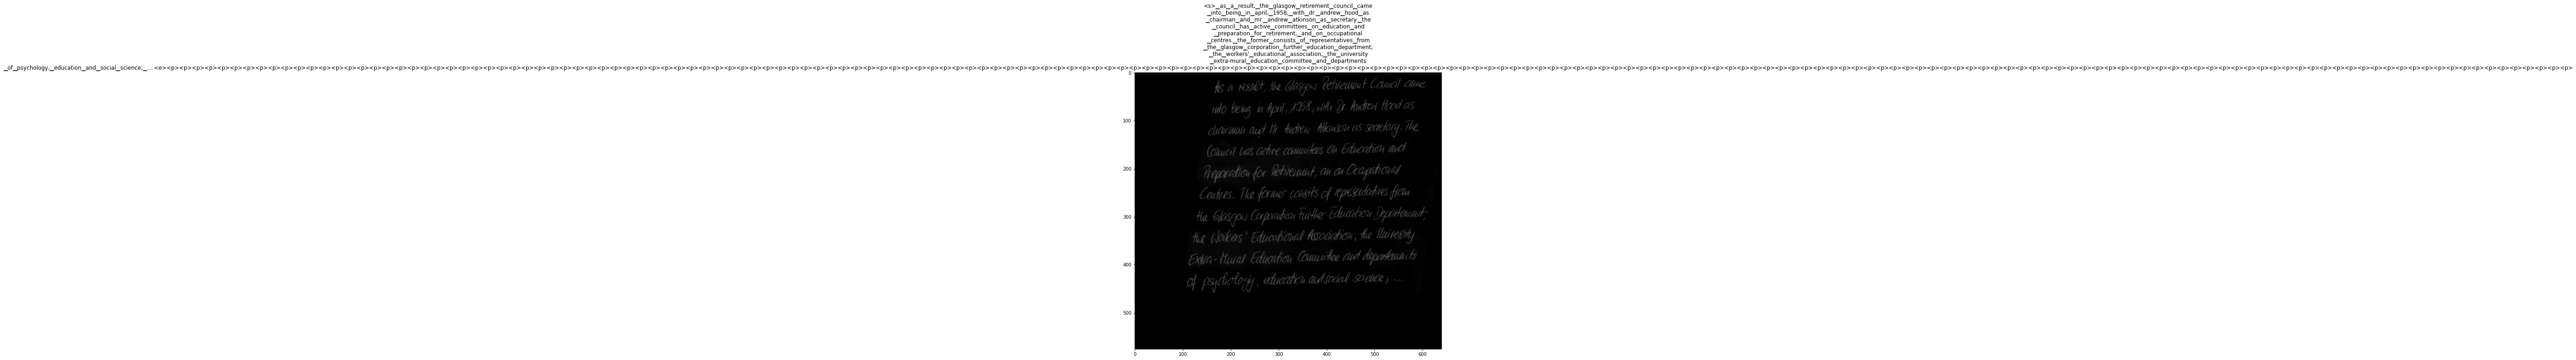

In [13]:
_plot(x[0], vmax=1, title=dataset.mapping.get_text(y))

In [ ]:
_plot(x[0, 0], vmax=1, title=convert_y_label_to_string(y[0], dataset.mapping))

In [ ]:
# Training

for _ in range(5):
    i = random.randint(0, len(dataset.data_train))
    x, y = dataset.data_train[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

In [ ]:
from einops import rearrange

In [ ]:
x, y = dataset.data_train[2]

In [ ]:
_plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

In [ ]:
p = 32
patches = rearrange(x.unsqueeze(0), 'b c (h p1) (w p2) -> b c (h w) p1 p2', p1 = p, p2 = p)

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i in range(15):
    ax = fig.add_subplot(1, 15, i + 1)
    ax.imshow(patches[0, 0, i + 160, :, :].squeeze(0), cmap='gray')

In [ ]:
# Testing

for _ in range(5):
    i = random.randint(0, len(dataset.data_test))
    x, y = dataset.data_test[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

In [ ]:
dataset = IAMSyntheticParagraphs()
dataset.prepare_data()
dataset.setup()
print(dataset)

In [ ]:
# Training

for _ in range(5):
    i = random.randint(0, len(dataset.data_train))
    x, y = dataset.data_train[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))